# About

This notebook is a Proof of Concept of machine learning application to predict desert items in ComprasGov.

# Imports

In [1]:
# Installing Required Libraries
# pip install pandas numpy matplotlib seaborn sqlalchemy scikit-learn scipy xgboost lightgbm catboost tpot sweetviz torch sqlalchemy

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from tpot import TPOTClassifier

# Importing User Sensible Data
from sql.postgres_connection import (dbname, password, host, port, database)
from sql.comprasgov_poc_item_deserto_sql import (full_sql_query, train_sql_query, test_sql_query)

# Data

## Database Connection

In [59]:
# Database Connection Function
def read_data_from_postgres(query):
    try:
        engine = create_engine(f'postgresql://{dbname}:{password}@{host}:{port}/{database}')
        df = pd.read_sql_query(query, engine)
        
    except Exception as e:
        print("An error occurred:", e)
        
    return df

# Test Connection
df = read_data_from_postgres(full_sql_query)
# df = read_data_from_postgres(train_sql_query)
# df = read_data_from_postgres(test_sql_query)

df_original = df.copy()
# df

# Data Exploration and Feature Engineering

In [60]:
# Describe columns types
df.dtypes

id_item                       int64
codigo_modalidade             int64
numero_item                   int64
valor_estimado              float64
quantidade_solicitada         int64
it_sg_uf                     object
it_sg_regiao                 object
codigo_item_catalogo         object
codigo_grupo_secao           object
codigo_classe_divisao        object
codigo_pdm_grupo             object
numero_uasg                  object
it_co_orgao                  object
it_co_orgao_vinculado        object
it_co_orgao_superior         object
it_in_tipo_administracao     object
in_orcamento_sigiloso          bool
in_deserto                     bool
in_agrupado                    bool
in_aberto                      bool
in_srp                         bool
in_exclusivo_me_epp            bool
in_federal                     bool
in_poder_executivo             bool
in_servico                     bool
in_pregao                      bool
it_no_orgao                  object
it_no_orgao_vinculado       

in_deserto = False:       311103
in_deserto = True:        23374
Proportion (False/True):  13.31 : 1
Percentage (False/Total): 6.99 %


<Axes: title={'center': 'Count (target)'}, xlabel='in_deserto'>

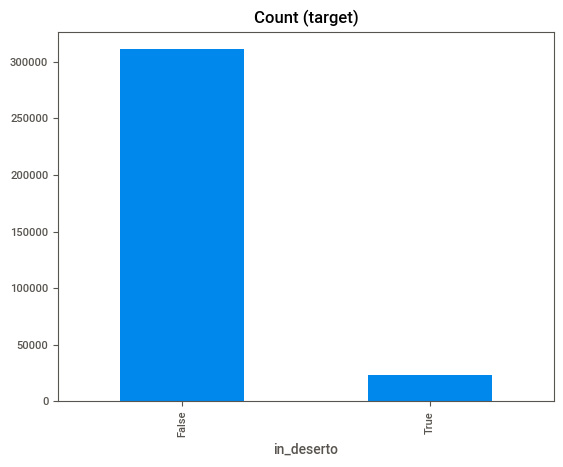

In [48]:
# Stats of target class
in_deserto_count = df.in_deserto.value_counts()
print('in_deserto = False:      ', in_deserto_count[0])
print('in_deserto = True:       ', in_deserto_count[1])
print('Proportion (False/True): ', round(in_deserto_count[0] / in_deserto_count[1], 2), ': 1')
print('Percentage (False/Total):', round(in_deserto_count[1] / df.shape[0] * 100, 2), '%')

# Plot target class
in_deserto_count.plot(kind='bar', title='Count (target)')

## SweetViz

In [61]:
# SweetViz Setup
target_feature ='in_deserto'
feature_config = sv.FeatureConfig(skip=None) # Possible parameters: skip, force_cat, force_num and force_text
my_report = sv.analyze(df, target_feat=target_feature, feat_cfg=feature_config)

# Export Report to HTML
my_report.show_html(filepath='sweetviz_report.html', 
                    open_browser=True, 
                    layout='vertical', 
                    scale=None)
                    
# Print Report to Notebook
# my_report.show_notebook(w="100%",
#                         h=None, 
#                         scale=None, 
#                         layout='vertical',
#                         filepath=None)

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Transformations

In [62]:
df.columns.to_list()

['id_item',
 'codigo_modalidade',
 'numero_item',
 'valor_estimado',
 'quantidade_solicitada',
 'it_sg_uf',
 'it_sg_regiao',
 'codigo_item_catalogo',
 'codigo_grupo_secao',
 'codigo_classe_divisao',
 'codigo_pdm_grupo',
 'numero_uasg',
 'it_co_orgao',
 'it_co_orgao_vinculado',
 'it_co_orgao_superior',
 'it_in_tipo_administracao',
 'in_orcamento_sigiloso',
 'in_deserto',
 'in_agrupado',
 'in_aberto',
 'in_srp',
 'in_exclusivo_me_epp',
 'in_federal',
 'in_poder_executivo',
 'in_servico',
 'in_pregao',
 'it_no_orgao',
 'it_no_orgao_vinculado',
 'it_no_orgao_superior',
 'nome_grupo_secao',
 'nome_classe_divisao',
 'nome_pdm_grupo',
 'descricao']

In [67]:
df = df_original.copy()
# df = df_oversampled.copy()

# Select rows by codigo_modalidade in [5, 6]
df = df[df['codigo_modalidade'].isin([5, 6])]

# Drop unuseful attributes
columns_to_ignore = [
    'in_orcamento_sigiloso',
    'in_srp',
    'in_exclusivo_me_epp',
    'in_federal',
    'in_poder_executivo',
    'codigo_modalidade',
    # 'id_item',
    # 'numero_item',
    # 'valor_estimado',
    # 'quantidade_solicitada',
    # 'it_sg_uf',
    # 'it_sg_regiao',
    # 'codigo_item_catalogo',
    # 'codigo_grupo_secao',
    # 'codigo_classe_divisao',
    # 'codigo_pdm_grupo',
    # 'numero_uasg',
    # 'it_co_orgao',
    # 'it_co_orgao_vinculado',
    # 'it_co_orgao_superior',
    # 'it_in_tipo_administracao',
    # 'in_deserto',
    # 'in_agrupado',
    # 'in_aberto',
    # 'in_servico',
    # 'in_pregao',
    # 'it_no_orgao',
    # 'it_no_orgao_vinculado',
    # 'it_no_orgao_superior',
    # 'nome_grupo_secao',
    # 'nome_classe_divisao',
    # 'nome_pdm_grupo',
    # 'descricao',
    ]

df = df.drop(columns_to_ignore, axis=1, inplace=False)


# Identify boolean columns in the DataFrame manually
# bool_cols = [
#     'in_deserto',
#     'in_agrupado',
#     'in_percentual',
#     'in_servico',
#     # 'in_aberto',
#     # 'in_srp',
#     # 'in_exclusivo_me_epp',
#     # 'in_federal',
#     # 'in_poder_executivo',
#     # 'in_pregao'
#     # 'in_orcamento_sigiloso',
#     ]

# Identify boolean columns in the DataFrame
# bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

# Convert boolean columns to integers
# df[bool_cols] = df[bool_cols].astype(int)


# Convert categorical columns to integers manually
categorical_cols = [
    'id_item',
    'codigo_item_catalogo',
    'codigo_grupo_secao',
    'codigo_classe_divisao',
    'codigo_pdm_grupo',
    'numero_uasg',
    'it_co_orgao',
    'it_co_orgao_vinculado',
    'it_co_orgao_superior',
    # 'it_sg_uf',
    # 'it_sg_regiao',
    # 'it_in_tipo_administracao',
]

# Identify categorical columns in the DataFrame
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert  categorical columns to integers
# df[categorical_cols] = df[categorical_cols].astype(int)
df[categorical_cols] = df[categorical_cols].fillna(-1).astype(int)

# Apply label encoding to convert categorical columns to integers
# df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

# Outliers Cleaning
df = df[(np.abs(stats.zscore(df['quantidade_solicitada'])) < 3)]
df = df[(np.abs(stats.zscore(df['valor_estimado'])) < 3)]
df = df[(np.abs(stats.zscore(df['numero_item'])) < 3)]

# Eliminate missing values on column valor_estimado
df = df.dropna(subset=['valor_estimado'])

# Select by  40000 < id_item < 400000
df = df[(df['id_item'] > 40000)]
# df = df[(df['id_item'] > 40000) & (df['id_item'] < 400000)]

# Eliminate rows with missing values
df = df.dropna()

df_etl = df.copy()
df

,id_item,numero_item,valor_estimado,quantidade_solicitada,it_sg_uf,it_sg_regiao,codigo_item_catalogo,codigo_grupo_secao,codigo_classe_divisao,codigo_pdm_grupo,...,in_aberto,in_servico,in_pregao,it_no_orgao,it_no_orgao_vinculado,it_no_orgao_superior,nome_grupo_secao,nome_classe_divisao,nome_pdm_grupo,descricao
0,180655,12,9.68,5,PE,NE,292427,65,6505,6143,...,False,False,False,TRIBUNAL REGIONAL FEDERAL - 5A REGIAO,JUSTICA FEDERAL,JUSTICA FEDERAL,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",DROGAS E MEDICAMENTOS,DEXAMETASONA,Dexametasona
1,180656,13,3.91,1,PE,NE,267502,65,6505,353,...,False,False,False,TRIBUNAL REGIONAL FEDERAL - 5A REGIAO,JUSTICA FEDERAL,JUSTICA FEDERAL,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",DROGAS E MEDICAMENTOS,ÁCIDO ACETILSALICÍLICO,Ácido Acetilsalicílico
2,197193,37,3376.00,3,PR,S,430794,65,6515,10565,...,False,False,True,EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES,MINISTERIO DA EDUCACAO,PRESIDENCIA DA REPUBLICA,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...","INSTRUMENTOS, EQUIPAMENTOS E SUPRIMENTOS MÉDIC...",PEÇA / COMPONENTE EQUIPAMENTO HOSPITALAR,"Peça , componente equipamento hospitalar"
3,180657,14,4.08,30,PE,NE,267203,65,6505,17708,...,False,False,False,TRIBUNAL REGIONAL FEDERAL - 5A REGIAO,JUSTICA FEDERAL,JUSTICA FEDERAL,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",DROGAS E MEDICAMENTOS,DIPIRONA SÓDICA,Dipirona Sódica
4,180658,15,6.54,1,PE,NE,267516,65,6505,3106,...,False,False,False,TRIBUNAL REGIONAL FEDERAL - 5A REGIAO,JUSTICA FEDERAL,JUSTICA FEDERAL,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...",DROGAS E MEDICAMENTOS,ATENOLOL,Atenolol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334472,356383,2,0.06,20000,RS,S,485227,66,6640,13426,...,False,False,True,PREFEITURA DE CAXIAS DO SUL,ESTADO DO RIO GRANDE DO SUL,REGIAO SUL,INSTRUMENTOS E EQUIPAMENTOS DE LABORATÓRIO,EQUIPAMENTOS E ARTIGOS DE LABORATÓRIO,LÂMINA LABORATÓRIO,Lâmina Laboratório
334473,197190,34,397.25,6,PR,S,474381,65,6515,18026,...,False,False,True,EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES,MINISTERIO DA EDUCACAO,PRESIDENCIA DA REPUBLICA,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...","INSTRUMENTOS, EQUIPAMENTOS E SUPRIMENTOS MÉDIC...",CABO,Cabo
334474,197191,35,365.17,18,PR,S,474381,65,6515,18026,...,False,False,True,EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES,MINISTERIO DA EDUCACAO,PRESIDENCIA DA REPUBLICA,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...","INSTRUMENTOS, EQUIPAMENTOS E SUPRIMENTOS MÉDIC...",CABO,Cabo
334475,197192,36,11607.00,2,PR,S,430794,65,6515,10565,...,False,False,True,EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES,MINISTERIO DA EDUCACAO,PRESIDENCIA DA REPUBLICA,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...","INSTRUMENTOS, EQUIPAMENTOS E SUPRIMENTOS MÉDIC...",PEÇA / COMPONENTE EQUIPAMENTO HOSPITALAR,"Peça , componente equipamento hospitalar"


## Balancing Target Class with Sklearn

In [68]:
df.dtypes

id_item                       int32
numero_item                   int64
valor_estimado              float64
quantidade_solicitada         int64
it_sg_uf                     object
it_sg_regiao                 object
codigo_item_catalogo          int32
codigo_grupo_secao            int32
codigo_classe_divisao         int32
codigo_pdm_grupo              int32
numero_uasg                   int32
it_co_orgao                   int32
it_co_orgao_vinculado         int32
it_co_orgao_superior          int32
it_in_tipo_administracao     object
in_deserto                     bool
in_agrupado                    bool
in_aberto                      bool
in_servico                     bool
in_pregao                      bool
it_no_orgao                  object
it_no_orgao_vinculado        object
it_no_orgao_superior         object
nome_grupo_secao             object
nome_classe_divisao          object
nome_pdm_grupo               object
descricao                    object
dtype: object

In [65]:
df = df_etl.copy()

# Split DataFrame into train, validation and test sets
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

# Separate the DataFrame into two based on the 'in_deserto' column
train_true = train[train['in_deserto'] == True]
train_false = train[train['in_deserto'] == False]

# Downsample the 'df_deserto_false' DataFrame to 0.5
train_false_downsampled = resample(train_false,
                                   replace=False,
                                   n_samples=int(0.5*len(train_false)),
                                   random_state=42)                                

# Oversample the 'df_deserto' DataFrame
train_true_oversampled = resample(train_true,
                             replace=True,
                             n_samples=len(train_false_downsampled),
                             random_state=42)

# Combine the DataFrames
train_balanced = pd.concat([train_false_downsampled, train_true_oversampled])

## Export Dataframe to CSV

In [54]:
# Export DataFrames to CSV
train.to_csv('output/comprasgov_poc_item_deserto_train.csv', index=False)
val.to_csv('output/comprasgov_poc_item_deserto_val.csv', index=False)
test.to_csv('output/comprasgov_poc_item_deserto_test.csv', index=False)
train_balanced.to_csv('output/comprasgov_poc_item_deserto_train_balanced.csv', index=False)

# Functions

## Transformations and Feature Engineering

In [31]:
def data_etl(df):

    columns_to_ignore = ['data_hora_prevista_abertura_sp', 'situacao_compra', 'id', 'it_sg_regiao', 'in_pregao', 
                        'descricao', 'it_no_orgao', 'it_no_orgao_vinculado', 'it_no_orgao_superior', 
                        'nome_grupo_secao', 'nome_classe_divisao', 'nome_pdm_grupo']

    df = df.drop(columns_to_ignore, axis=1, inplace=False)

    # Identify boolean columns in the DataFrame
    # bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers
    # df[bool_cols] = df[bool_cols].astype(int)

    # Identify categorical columns in the DataFrame
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

    return df

## Outliers Analysis

In [32]:
df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

,numero_item,valor_estimado,quantidade_solicitada,variacao_minima_entre_lances,it_sg_uf,codigo_item_catalogo,it_in_tipo_administracao,codigo_grupo_secao,codigo_classe_divisao,codigo_pdm_grupo,...,in_orcamento_sigiloso,in_deserto,in_agrupado,in_aberto,in_srp,in_exclusivo_me_epp,in_federal,in_poder_executivo,in_percentual,in_servico
0,59,3292.14,2,1.0,SP,603638,5,84,8415,1203,...,False,False,False,False,False,True,True,True,True,False
1,60,353.08,2,1.0,SP,475757,5,65,6525,18113,...,False,False,False,False,False,True,True,True,True,False
2,61,1083.69,2,1.0,SP,390667,5,65,6532,421,...,False,False,False,False,False,True,True,True,True,False
3,62,1494.99,1,1.0,SP,397946,5,42,4240,1377,...,False,False,False,False,False,True,True,True,True,False
4,1,9992.42,1,10.0,MT,3212,3,6,64,643,...,False,False,False,False,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216671,54,329.92,2,1.0,SP,440398,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216672,55,329.92,1,1.0,SP,402131,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216673,56,124.64,1,1.0,SP,449179,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216674,57,70.00,2,1.0,SP,459483,5,72,7210,19710,...,False,True,False,False,False,True,True,True,True,False


In [16]:
def remove_outliers(df):
    return df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

# Modeling

## Models and Metrics

In [35]:
# AutoML for Model Selection and Ranking
# def run_automl(X_train, y_train):
#     tpot = TPOTClassifier(generations=2, population_size=20, verbosity=2)
#     tpot.fit(X_train, y_train)
#     return tpot

# Train, Test, and Evaluate Machine Learning Models
def train_test_evaluate_models(X, y, X_val, y_val):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Run AutoML
    # automl_model = run_automl(X_train, y_train)
    
    models = {
        # "AutoML": automl_model,
        "RandomForest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(),
        "LightGBM": LGBMClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0)
    }
    
    metrics = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Validate with external CSV
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        metrics[name] = {
            'Test Accuracy': accuracy,
            'Validation Accuracy': val_accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        }
        
        print(f"{name} Model Metrics:")
        print(f"Test Accuracy: {accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
    return metrics

# Main

In [36]:
if __name__ == "__main__":
    # Reading Data from PostgreSQL
    df = read_data_from_postgres(train_sql_query)
    
    # ETL Operations
    df = data_etl(df)
    
    # Remove Outliers
    df = remove_outliers(df)
    
    # Prepare Data for Models
    X = df.drop('in_deserto', axis=1)  # 'in_deserto' is the target attribute
    y = df['in_deserto']
    
    # Read Validation Data from PostgreSQL
    df_val = read_data_from_postgres(test_sql_query)
    df_val = data_etl(df_val)

    X_val = df_val.drop('in_deserto', axis=1)
    y_val = df_val['in_deserto']
    
    # Train, Test, and Evaluate Models
    metrics = train_test_evaluate_models(X, y, X_val, y_val)
    
    # Comparative Metrics
    print("\nComparative Metrics:")
    for name, metric in metrics.items():
        print(f"{name} - Test Accuracy: {metric['Test Accuracy']}, Validation Accuracy: {metric['Validation Accuracy']}")

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.924659236915527

Generation 2 - Current best internal CV score: 0.9279395514165222

Best pipeline: KNeighborsClassifier(RobustScaler(input_matrix), n_neighbors=49, p=1, weights=distance)


Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9252158290297474

Generation 2 - Current best internal CV score: 0.9281941600882753

Best pipeline: KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=15, p=1, weights=distance)
AutoML Model Metrics:
Test Accuracy: 0.9304627919094312
Validation Accuracy: 0.9133812303547373
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96     38493
        True       0.69      0.39      0.50      3729

    accuracy                           0.93     42222
   macro avg       0.82      0.69      0.73     42222
weighted avg       0.92      0.93      0.92     42222

RandomForest Model Metrics:
Test Accuracy: 0.9388944152337644
Validation Accuracy: 0.93242029636282
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     38493
        True       0.81      0.41      0.54      3729

    accuracy                 

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels.